# *Student Performances Data Analysis*

## **Database Connection and Data Loading**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from urllib.parse import quote_plus
import sqlalchemy
import psycopg2

In [2]:
username = 'root'     
password = quote_plus('Data130506!')
host = 'localhost'       
port = '3306'            
database = 'student_performance'  
connection_str = f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}"

engine = sqlalchemy.create_engine(connection_str)


In [3]:
attendance = pd.read_sql("SELECT * FROM attendance", con=engine)
homework = pd.read_sql("SELECT * FROM homework", con=engine)
performance = pd.read_sql("SELECT * FROM performance", con=engine)
communication = pd.read_sql("SELECT * FROM communication", con=engine)
students = pd.read_sql("SELECT * FROM students", con=engine)

## **Data Cleaning and Preparation**

### **Attendance dataset**

In [4]:
attendance.sample(5)

,student_id,date,subject,attendance_status
66090,S00693,2024-11-15,English,late
136364,S05951,2024-06-20,Math,Absent
197074,S02392,2024-09-18,History,PRESENT
64274,S07006,2024-08-24,Science,Late
231510,S11984,2024-04-20,Geography,left early


In [5]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364680 entries, 0 to 364679
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   student_id         364680 non-null  object
 1   date               364680 non-null  object
 2   subject            364680 non-null  object
 3   attendance_status  364680 non-null  object
dtypes: object(4)
memory usage: 11.1+ MB


#### Clean mixed date formats with `pd.to_datetime`

In [6]:
attendance['date'] = pd.to_datetime(attendance['date'], format='mixed', dayfirst=True)

In [7]:
attendance['date'].isna().sum()

0

#### Fix inconsistent attendance statuses using a custom cleaning function

In [8]:
attendance['attendance_status'].unique()

array(['Present', 'PRESENT ', 'excused', ' late', 'Absent', 'left early',
       'Late', 'absnt'], dtype=object)

In [9]:
attendance['attendance_status'] = attendance['attendance_status'].str.strip()


In [10]:
def attendance_status(x):
    if x == 'late':
        return 'Late'
    elif x == 'absnt':
        return 'Absent'
    elif x == 'PRESENT':
        return 'Present'
    elif x == 'excused':
        return 'Excused'
    elif x == 'left early':
        return 'Left Early'
    else:
        return x

In [11]:
attendance['attendance_status'] = attendance['attendance_status'].apply(attendance_status)

In [12]:
attendance['attendance_status'].unique()

array(['Present', 'Excused', 'Late', 'Absent', 'Left Early'], dtype=object)

### **Homework dataset**

In [13]:
homework.sample(5)

,student_id,subject,assignment_name,due_date,status,grade_feedback,guardian_signature
56782,S02559,English,Get case.,2024-09-10,✔,A+,No
32370,S09942,Arabic,Offer teach teacher.,2025-02-19,✅,A,No
35394,S10590,English,Imagine claim first get.,2025-01-30,pending,C,
47413,S08536,Arabic,Accept population.,2025-02-11,pending,D,Yes
2920,S11624,History,Condition his hear.,2024-11-25,not done,D,Yes


In [14]:
homework.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60780 entries, 0 to 60779
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   student_id          60780 non-null  object
 1   subject             60780 non-null  object
 2   assignment_name     60780 non-null  object
 3   due_date            60780 non-null  object
 4   status              60780 non-null  object
 5   grade_feedback      60780 non-null  object
 6   guardian_signature  60780 non-null  object
dtypes: object(7)
memory usage: 3.2+ MB


#### Clean mixed date formats with `pd.to_datetime`

In [15]:
homework[homework['student_id'] == 'S11282']

,student_id,subject,assignment_name,due_date,status,grade_feedback,guardian_signature
10102,S11282,Geography,Important mother.,10/03/2024,❌,C-,
11914,S11282,History,Cut security.,2024-11-03,not done,B,No
39662,S11282,Math,Teach project.,2024-12-11,not done,F,No
51640,S11282,Science,Form wear.,01/04/2025,✅,B-,No


In [16]:
homework['due_date'] = pd.to_datetime(homework['due_date'], format = 'mixed', dayfirst = True)

In [17]:
homework[homework['student_id'] == 'S11282']

,student_id,subject,assignment_name,due_date,status,grade_feedback,guardian_signature
10102,S11282,Geography,Important mother.,2024-03-10,❌,C-,
11914,S11282,History,Cut security.,2024-11-03,not done,B,No
39662,S11282,Math,Teach project.,2024-12-11,not done,F,No
51640,S11282,Science,Form wear.,2025-04-01,✅,B-,No


#### Fix inconsistent statuses using a custom cleaning function

In [18]:
homework['status'] = homework['status'].str.strip()

In [19]:
homework['status'].unique()

array(['❌', 'Done', '✅', '✔', 'not done', 'pending'], dtype=object)

In [20]:
def homework_status(x):
    if x in ['❌', 'not done']:
        return 'Not Done'
    elif x in ['✅', '✔', 'Done']:
        return 'Done'
    else:
        return 'Pending'

In [21]:
homework['status'] = homework['status'].apply(homework_status)

In [22]:
homework['status'].unique()

array(['Not Done', 'Done', 'Pending'], dtype=object)

#### Change guardian signature encoding

In [23]:
homework['guardian_signature'].unique()

array(['Yes', 'No', ' '], dtype=object)

In [24]:
homework['guardian_signature'] = homework['guardian_signature'].replace(' ', np.nan)

In [25]:
homework['guardian_signature'] = homework['guardian_signature'].map({'No': 0, 'Yes': 1})

In [26]:
homework['guardian_signature'].unique()

array([ 1.,  0., nan])

#### Since the grades are stored as text, we convert them to GPA values for easier numeric analysis.

In [27]:
def convert_grades(x):
    mapping = {
        "A+": 4.3, "A": 4.0, "A-": 3.7,
        "B+": 3.3, "B": 3.0, "B-": 2.7,
        "C+": 2.3, "C": 2.0, "C-": 1.7,
        "D+": 1.3, "D": 1.0, "D-": 0.7,
        "F": 0.0
    }
    return pd.Series(x).map(mapping)

In [28]:
homework['GPA_grade'] = convert_grades(homework['grade_feedback'])

### **Performance dataset**

In [29]:
performance.sample(5)

,student_id,subject,exam_score,homework_completion,teacher_comments
14455,S06312,Arabic,57,80%,Per accept follow yes pretty road hotel.
11471,S09267,Math,103,80%,Sing gun important foreign sit cut newspaper s...
12668,S11648,History,44,80%,Two close school forward together specific hit...
31330,S02715,Geography,94,-5,
23716,S11267,Science,58,90,Standard your instead painting drop knowledge ...


In [30]:
performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36468 entries, 0 to 36467
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   student_id           36468 non-null  object
 1   subject              36468 non-null  object
 2   exam_score           36468 non-null  object
 3   homework_completion  36468 non-null  object
 4   teacher_comments     36468 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


#### Fixing `exam_score > 100`

In [31]:
performance['exam_score'] = performance['exam_score'].str.strip().astype(int)

In [32]:
performance['exam_score'].unique()

array([ 76,  91,  92,  40,  57,  89,  60,  95,  50,  68,  97,  74,  47,
        45,  90,  70, 109,  53,  78, 102,  66, 103, 110,  44, 106,  86,
        79,  46,  64, 105, 101,  98,  56,  72,  96,  62,  41,  48,  88,
        61,  81,  84,  99,  83,  69,  87,  85,  58, 107, 104,  94,  52,
       108, 100,  54,  75,  63,  67,  49,  42,  93,  55,  71,  59,  43,
        82,  80,  65,  73,  77,  51])

In [33]:
performance = performance[performance['exam_score'] <= 100]

In [34]:
performance.describe()

,exam_score
count,31329.000000
mean,69.955664
std,17.653133
min,40.000000
25%,55.000000
50%,70.000000
75%,85.000000
max,100.000000


#### Removing `%` from `homework_completion` values

In [35]:
performance['homework_completion'] = performance['homework_completion'].apply(lambda x: int(str(x).replace('%', '')))

In [36]:
performance = performance[performance['homework_completion'] > 0]

In [37]:
performance['homework_completion'].unique()

array([ 90, 100,  95,  80], dtype=int64)

### **Communication dataset**

In [38]:
communication.sample(5)

,student_id,date,message_type,message_content
375,S04821,2024-09-17,Teacher to Parent,Up possible great benefit care hundred will hi...
24060,S11317,2025-03-05,Teacher to Parent,Wear media attorney into born wind organizatio...
2612,S02193,2025-02-08,Teacher to Parent,My our year miss agree protect moment number y...
2497,S11544,2024-12-25,Parent to Teacher,Find garden under will stock radio manager bui...
21356,S05719,2024-11-27,Parent to Teacher,Not break view else personal analysis wind age...


In [39]:
communication.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24312 entries, 0 to 24311
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   student_id       24312 non-null  object
 1   date             24312 non-null  object
 2   message_type     24312 non-null  object
 3   message_content  24312 non-null  object
dtypes: object(4)
memory usage: 759.9+ KB


#### Clean mixed date formats with `pd.to_datetime`

In [40]:
communication['date'] = pd.to_datetime(communication['date'], format = 'mixed', dayfirst = True)

In [41]:
communication['message_type'].unique()

array(['Automated Reminder', 'Parent to Teacher', 'Teacher to Parent'],
      dtype=object)

#### Removing rows where `message_content` is empty

In [42]:
communication['message_content'] = communication['message_content'].str.strip()

In [43]:
communication[communication['message_content'] == ''].head(5)

,student_id,date,message_type,message_content
6,S06925,2025-02-13,Automated Reminder,
11,S05140,2024-09-17,Automated Reminder,
28,S10194,2025-02-16,Teacher to Parent,
75,S04642,2024-11-29,Parent to Teacher,
79,S03451,2024-10-14,Parent to Teacher,


#### Only 5% of rows are empty, so dropping them is safer and simplifies analysis

In [44]:
np.round(len(communication[communication['message_content'] == '']) / len(communication) * 100, 2)

5.05

In [45]:
communication = communication[communication['message_content'] != '']

### **Students dataset**

In [46]:
students.sample(5)

,student_id,full_name,date_of_birth,grade_level,emergency_contact
4384,S04385,Eric Davenport,2017-12-22,Grade 4,3152211745
2064,S02065,Michael Ford,2018-10-22,Grade 1,599.833.6689
648,S00649,Ryan Owen,2006-06-13,Grade 2,916.391.1924x332
1357,S01358,Donald King,2011-11-11,Grade 3,(648)822-8443x743
10443,S10444,Scott Young,2016-09-29,Grade 1,6122800112


In [47]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12156 entries, 0 to 12155
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   student_id         12156 non-null  object
 1   full_name          12156 non-null  object
 2   date_of_birth      12156 non-null  object
 3   grade_level        12156 non-null  object
 4   emergency_contact  12156 non-null  object
dtypes: object(5)
memory usage: 475.0+ KB


#### Correct format of `full_name`

In [48]:
students.iloc[5846]

student_id                    S05847
full_name              erica alvarez
date_of_birth             2006-08-19
grade_level                  Grade 4
emergency_contact    +1-422-581-3030
Name: 5846, dtype: object

In [49]:
students['full_name'] = students['full_name'].apply(lambda x: x.title())

In [50]:
students.iloc[5846]

student_id                    S05847
full_name              Erica Alvarez
date_of_birth             2006-08-19
grade_level                  Grade 4
emergency_contact    +1-422-581-3030
Name: 5846, dtype: object

#### Clean mixed date formats with `pd.to_datetime`

In [51]:
students['date_of_birth'] = pd.to_datetime(students['date_of_birth'], format = 'mixed', dayfirst = True)

#### Converting `grade_level` to integer for analysis

In [52]:
students['grade_level'].unique()

array(['Grade 3', 'Grade 5', 'Grade 2', 'Grade 4', 'Grade 1'],
      dtype=object)

In [53]:
def grade(x):
    return int(x.replace('Grade', '').strip())

In [54]:
students['grade_level'] = students['grade_level'].apply(grade)

In [55]:
students['grade_level'].unique()

array([3, 5, 2, 4, 1], dtype=int64)

#### Select Relevant Columns and Update MySQL Table

In [56]:
performance = performance.drop('teacher_comments', axis = 'columns')

In [57]:
communication = communication.drop('message_content', axis='columns')

In [58]:
students = students.drop('emergency_contact', axis='columns')

#### Function to add cleaned tables into MySQL 

In [59]:
def write_table(df, table_name):
    return df.to_sql(
        name=table_name,
        con=engine,
        if_exists='replace',
        index=False
    )

In [60]:
write_table(attendance, 'attendance_cleaned')

364680

In [61]:
write_table(homework, 'homework_cleaned')

60780

In [62]:
write_table(performance, 'performance_cleaned')

24964

In [63]:
write_table(communication, 'communication_cleaned')

23085

In [64]:
write_table(students, 'students_cleaned')

12156

## **EDA**

### **Data Exploration**

Overall date range of the attendance dataset

In [65]:
query = """
SELECT
    MIN(date) AS start_date,
    MAX(date) AS end_date
FROM attendance_cleaned;
"""

pd.read_sql(query, engine)

,start_date,end_date
0,2024-03-09,2025-03-09


How many students are in the dataset?

In [66]:
query = """
SELECT COUNT(DISTINCT student_id) as students_number FROM students_cleaned;
"""

pd.read_sql(query, engine)

,students_number
0,12156


How many students are there per grade level?

In [67]:
query = """
SELECT 
    grade_level,
    COUNT(student_id) as student_number 
FROM students_cleaned
GROUP BY grade_level
ORDER BY grade_level
"""

pd.read_sql(query, engine)

,grade_level,student_number
0,1,2383
1,2,2400
2,3,2447
3,4,2454
4,5,2472


What is the average of exam scores and homework compeltion?

In [68]:
query = """
SELECT 
    subject, 
    AVG(exam_score) as avg_exam_score, 
    AVG(homework_completion) as avg_homework_completion
FROM performance_cleaned
GROUP BY subject
"""

pd.read_sql(query, engine)

,subject,avg_exam_score,avg_homework_completion
0,Arabic,69.9180,91.3631
1,Math,69.9449,91.2292
2,Science,70.1714,91.3957
3,English,70.0463,91.0955
4,History,69.9504,91.2157
5,Geography,69.9494,91.3209


Which students have the highest and lowest average exam scores?

In [69]:
query = """
SELECT 
    AVG(exam_score) as avg_exam_score
FROM performance_cleaned
"""

pd.read_sql(query, engine)

,avg_exam_score
0,69.9969


Lowest(avg score = 40)

In [70]:
query = """
SELECT 
    student_id,
    AVG(exam_score) as avg_exam_score
FROM performance_cleaned
GROUP BY student_id
HAVING avg_exam_score = 40
ORDER BY avg_exam_score
"""

lowest_average = pd.read_sql(query, engine)

In [71]:
len(lowest_average)

52

Highest(avg score = 100)

In [72]:
query = """
SELECT 
    student_id,
    AVG(exam_score) as avg_exam_score
FROM performance_cleaned
GROUP BY student_id
HAVING avg_exam_score = 100
ORDER BY avg_exam_score
"""

highest_average = pd.read_sql(query, engine)

In [73]:
len(highest_average)

49

How many unique dates are recorded in the attendance table?

In [74]:
query = """
SELECT
    COUNT(DISTINCT date) as num_unique_dates
FROM attendance_cleaned
"""

pd.read_sql(query, engine)

,num_unique_dates
0,366


Which message types are most common in the communication table?

In [75]:
query = """
SELECT
    message_type,
    COUNT(*) as messages_num
FROM communication_cleaned
GROUP BY message_type
"""

pd.read_sql(query, engine)

,message_type,messages_num
0,Automated Reminder,7695
1,Parent to Teacher,7636
2,Teacher to Parent,7754


How many homework assignments are recorded per subject?

In [76]:
query = """
SELECT
    subject,
    COUNT(DISTINCT assignment_name) as assignment_count
FROM homework_cleaned
GROUP by subject
ORDER BY assignment_count DESC
"""

pd.read_sql(query, engine)

,subject,assignment_count
0,English,9878
1,Geography,9873
2,Science,9797
3,Arabic,9786
4,History,9784
5,Math,9736


### **Attendance Patterns and Trends**

What is the total number of attendance statuses records per subject?

In [77]:
# We count 'Late', 'Left Early', 'Present' as 'Attended Lesson', because formally they where on lesson and we want to focus more on % between 'Absent', 'Excused' and 'Attended Lesson'
query = """
SELECT 
    subject,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated,
    COUNT(*) AS count,
    SUM(COUNT(*)) OVER (PARTITION BY subject) AS full_count_by_subject,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY subject), 2) AS percentage
FROM attendance_cleaned
GROUP BY subject, attendance_status_updated
ORDER BY subject, attendance_status_updated;
"""

subject_attendance_summary = pd.read_sql(query, engine)

In [78]:
query = """
with cte as(
SELECT 
    subject,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated,
    COUNT(*) AS count,
    SUM(COUNT(*)) OVER (PARTITION BY subject) AS full_count_by_subject,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY subject), 2) AS percentage
FROM attendance_cleaned
GROUP BY subject, attendance_status_updated
)

SELECT DISTINCT
    subject,
    full_count_by_subject as total_num_statuses
FROM cte
ORDER BY full_count_by_subject
"""

pd.read_sql(query, engine)

,subject,total_num_statuses
0,History,60485.0
1,Geography,60640.0
2,English,60684.0
3,Arabic,60749.0
4,Science,60881.0
5,Math,61241.0


Math has the highest total number of attendance records (61,241), across all statuses (Present, Absent, Excused, etc.). This suggests that Math likely had either more students enrolled or more lessons overall — or both.

Which subjects have the lowest average attendance rate?

In [79]:
subject_attendance_summary[subject_attendance_summary['attendance_status_updated'] == 'Attended Lesson'].sort_values('percentage')

,subject,attendance_status_updated,count,full_count_by_subject,percentage
1,Arabic,Attended Lesson,37901,60749.0,62.39
10,History,Attended Lesson,37808,60485.0,62.51
7,Geography,Attended Lesson,37919,60640.0,62.53
4,English,Attended Lesson,37955,60684.0,62.55
13,Math,Attended Lesson,38333,61241.0,62.59
16,Science,Attended Lesson,38150,60881.0,62.66


In [80]:
subject_attendance_summary[subject_attendance_summary['attendance_status_updated'] == 'Absent'].sort_values('percentage')

,subject,attendance_status_updated,count,full_count_by_subject,percentage
3,English,Absent,15105,60684.0,24.89
15,Science,Absent,15167,60881.0,24.91
9,History,Absent,15080,60485.0,24.93
6,Geography,Absent,15200,60640.0,25.07
12,Math,Absent,15364,61241.0,25.09
0,Arabic,Absent,15313,60749.0,25.21


In [81]:
subject_attendance_summary[subject_attendance_summary['attendance_status_updated'] == 'Excused'].sort_values('percentage')

,subject,attendance_status_updated,count,full_count_by_subject,percentage
14,Math,Excused,7544,61241.0,12.32
2,Arabic,Excused,7535,60749.0,12.40
8,Geography,Excused,7521,60640.0,12.40
17,Science,Excused,7564,60881.0,12.42
5,English,Excused,7624,60684.0,12.56
11,History,Excused,7597,60485.0,12.56


The attendance distribution is remarkably consistent across subjects: roughly 62% of sessions were attended, 25% absent, and 12% excused. This indicates no subject has a significant deviation in attendance behavior.

Which students have the highest and lowest attendance rates?

In [82]:
query = """
SELECT
    student_id,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated,
    COUNT(*) as count,
    SUM(COUNT(*)) OVER (Partition by student_id) as full_count_by_student,
    ROUND(COUNT(*)/SUM(COUNT(*)) OVER (Partition by student_id) , 2) * 100 as percentage
FROM attendance_cleaned
GROUP BY student_id, attendance_status_updated
ORDER BY student_id, attendance_status_updated
"""

students_attendance_summary = pd.read_sql(query, engine)

In [83]:
students_attendance_summary[['student_id', 'attendance_status_updated', 'percentage']].head(6)

,student_id,attendance_status_updated,percentage
0,S00001,Absent,26.0
1,S00001,Attended Lesson,67.0
2,S00001,Excused,8.0
3,S00002,Absent,36.0
4,S00002,Attended Lesson,64.0
5,S00003,Absent,16.0


In [84]:
query = """
with cte as (
SELECT
    student_id,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated,
    COUNT(*) as count,
    SUM(COUNT(*)) OVER (Partition by student_id) as full_count_by_student,
    ROUND(COUNT(*)/SUM(COUNT(*)) OVER (Partition by student_id) , 2) * 100 as percentage
FROM attendance_cleaned
GROUP BY student_id, attendance_status_updated
ORDER BY student_id, attendance_status_updated
),

cte_percentage AS (
    SELECT
        student_id,
        percentage as attendance_percentage,
        attendance_status_updated,
        MIN(percentage) OVER () AS min_percentage,
        MAX(percentage) OVER () AS max_percentage
    FROM cte
    WHERE attendance_status_updated = 'Attended Lesson'
)

SELECT 
    cp.student_id,
    s.full_name, 
    cp.attendance_percentage
FROM cte_percentage cp
JOIN students_cleaned s ON s.student_id = cp.student_id
WHERE attendance_percentage = min_percentage
   OR attendance_percentage = max_percentage
ORDER BY attendance_percentage;

"""

pd.read_sql(query, engine)

,student_id,full_name,attendance_percentage
0,S08730,Zachary Mitchell,25.0
1,S04480,Victoria Nguyen,25.0
2,S00311,Alexandra King,100.0


Alexandra King has the highest attendance rate at 100%, while Zachary Mitchell and Victoria Nguyen have the lowest attendance rate at 25%.

What is average attendance rate?

In [85]:
query = """
WITH cte AS (
SELECT
    student_id,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated,
    COUNT(*) as count,
    SUM(COUNT(*)) OVER (Partition by student_id) as full_count_by_student,
    ROUND(COUNT(*)/SUM(COUNT(*)) OVER (Partition by student_id) , 2) * 100 as percentage
FROM attendance_cleaned
GROUP BY student_id, attendance_status_updated
ORDER BY student_id, attendance_status_updated
)

SELECT
ROUND(AVG(percentage), 2) as avg_attendance_percentage
FROM cte
WHERE attendance_status_updated = 'Attended Lesson'
"""

pd.read_sql(query, engine)

,avg_attendance_percentage
0,62.62


How does attendance vary by grade level?

In [86]:
query = """
WITH cte AS (
SELECT
    student_id,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated,
    COUNT(*) as count,
    SUM(COUNT(*)) OVER (Partition by student_id) as full_count_by_student,
    ROUND(COUNT(*)/SUM(COUNT(*)) OVER (Partition by student_id) , 2) * 100 as percentage
FROM attendance_cleaned
GROUP BY student_id, attendance_status_updated
ORDER BY student_id, attendance_status_updated
)

SELECT 
    sc.grade_level, 
    ROUND(AVG(c.percentage), 2) as avg_attendance_percentage
FROM cte c
JOIN students_cleaned sc ON sc.student_id = c.student_id
WHERE attendance_status_updated = 'Attended Lesson'
GROUP BY grade_level
ORDER BY grade_level
"""

pd.read_sql(query, engine)

,grade_level,avg_attendance_percentage
0,1,62.57
1,2,62.74
2,3,62.57
3,4,62.69
4,5,62.52


Attendance rate almost does not vary between grades.

Are there any noticeable seasonal attendance patterns?

In [87]:
query = """
WITH cte AS (
SELECT
    student_id,
    date,
    CASE 
        WHEN MONTH(date) IN (12, 1, 2) THEN 'Winter'
        WHEN MONTH(date) IN (3, 4, 5) THEN 'Spring'
        WHEN MONTH(date) IN (6, 7, 8) THEN 'Summer'
        WHEN MONTH(date) IN (9, 10, 11) THEN 'Autumn'
    END as season,
    CASE 
        WHEN attendance_status IN ('Late','Left Early','Present') THEN 'Attended Lesson'
        ELSE attendance_status 
    END AS attendance_status_updated
FROM attendance_cleaned
)

SELECT
    season,
    attendance_status_updated,
    COUNT(season) as count,
    SUM(COUNT(season)) OVER (Partition BY season) as season_count,
    ROUND(COUNT(season)/ SUM(COUNT(season)) OVER (Partition BY season), 2) * 100 as percentage
FROM cte
GROUP BY season, attendance_status_updated
ORDER BY season, attendance_status_updated
"""

pd.read_sql(query, engine)

,season,attendance_status_updated,count,season_count,percentage
0,Autumn,Absent,22723,90892.0,25.0
1,Autumn,Attended Lesson,56853,90892.0,63.0
2,Autumn,Excused,11316,90892.0,12.0
3,Spring,Absent,22954,92799.0,25.0
4,Spring,Attended Lesson,58475,92799.0,63.0
5,Spring,Excused,11370,92799.0,12.0
6,Summer,Absent,23005,91515.0,25.0
7,Summer,Attended Lesson,56997,91515.0,62.0
8,Summer,Excused,11513,91515.0,13.0
9,Winter,Absent,22547,89474.0,25.0


As we can see, we have any seasonal patterns.

### **Homework and Guardian Engagement**

How many homework assignments were completed vs not completed overall?

In [88]:
query = """
SELECT 
    status,
    COUNT(status) as count,
    SUM(COUNT(status)) OVER () as total_homeworks,
    ROUND(COUNT(status) / SUM(COUNT(status)) OVER (), 2) * 100 as percentage
FROM homework_cleaned
GROUP BY status
ORDER BY ROUND(COUNT(status) / SUM(COUNT(status)) OVER (), 2) * 100 DESC
"""

pd.read_sql(query, engine)

,status,count,total_homeworks,percentage
0,Done,30381,60780.0,50.0
1,Not Done,20385,60780.0,34.0
2,Pending,10014,60780.0,16.0


Which subjects have the highest homework completion rates?

In [89]:
query = """
SELECT 
    subject,
    status,
    COUNT(status) as count,
    SUM(COUNT(status)) OVER (PARTITION BY subject) as total_homeworks,
    ROUND(COUNT(status) / SUM(COUNT(status)) OVER (PARTITION BY subject), 2) * 100 as percentage
FROM homework_cleaned
GROUP BY subject, status
ORDER BY subject, status
"""

pd.read_sql(query, engine)

,subject,status,count,total_homeworks,percentage
0,Arabic,Done,5044,10106.0,50.0
1,Arabic,Not Done,3367,10106.0,33.0
2,Arabic,Pending,1695,10106.0,17.0
3,English,Done,5100,10209.0,50.0
4,English,Not Done,3430,10209.0,34.0
5,English,Pending,1679,10209.0,16.0
6,Geography,Done,5135,10179.0,50.0
7,Geography,Not Done,3397,10179.0,33.0
8,Geography,Pending,1647,10179.0,16.0
9,History,Done,5030,10110.0,50.0


Homework completion rates are almost the same between the subjects.

What is the average homework grade per subject?

In [90]:
query = """
SELECT 
    subject, 
    ROUND(AVG(GPA_grade), 2) as avg_GPA
FROM homework_cleaned
GROUP BY subject
"""

pd.read_sql(query, engine)

,subject,avg_GPA
0,Science,2.35
1,History,2.34
2,Arabic,2.33
3,Geography,2.34
4,Math,2.33
5,English,2.35


How often do guardians sign homework assignments?

In [91]:
query = """
SELECT
    CASE
        WHEN guardian_signature = 1 THEN 'Signed'
        WHEN guardian_signature = 0 THEN 'Not Signed'
        WHEN guardian_signature IS NULL THEN 'NULL'
    END AS signature_status,
    COUNT(*) AS count,
    SUM(COUNT(*)) OVER () as full,
    COUNT(*)/SUM(COUNT(*)) OVER () as percentage
FROM homework_cleaned
GROUP BY
    CASE
        WHEN guardian_signature = 1 THEN 'Signed'
        WHEN guardian_signature = 0 THEN 'Not Signed'
        WHEN guardian_signature IS NULL THEN 'NULL'
    END;
"""

pd.read_sql(query, engine)

,signature_status,count,full,percentage
0,Signed,20348,60780.0,0.3348
1,Not Signed,20372,60780.0,0.3352
2,NULL,20060,60780.0,0.3300


Do students with guardian signatures have higher homework grades?

In [92]:
query = """
SELECT
    CASE
        WHEN guardian_signature = 1 THEN 'Signed'
        WHEN guardian_signature = 0 THEN 'Not Signed'
        WHEN guardian_signature IS NULL THEN 'NULL'
    END AS signature_status,
    ROUND(AVG(GPA_grade), 2) avg_GPA
FROM homework_cleaned
GROUP BY
    CASE
        WHEN guardian_signature = 1 THEN 'Signed'
        WHEN guardian_signature = 0 THEN 'Not Signed'
        WHEN guardian_signature IS NULL THEN 'NULL'
    END;
"""

pd.read_sql(query, engine)

,signature_status,avg_GPA
0,Signed,2.34
1,Not Signed,2.35
2,NULL,2.34


Which grade level has the lowest guardian signature participation?

We exclude NULL values from the calculation so that the participation rate reflects only records where a signature status (0 or 1) is actually known.

In [93]:
query = """
SELECT
    sc.grade_level,
    COUNT(guardian_signature) AS with_signature_record,
    SUM(guardian_signature) AS signed_count,
    ROUND(SUM(guardian_signature)/COUNT(guardian_signature), 2) * 100 AS signature_rate
FROM homework_cleaned hc
JOIN students_cleaned sc ON sc.student_id = hc.student_id
GROUP BY grade_level
ORDER BY grade_level
"""

pd.read_sql(query, engine)

,grade_level,with_signature_record,signed_count,signature_rate
0,1,8063,4002.0,50.0
1,2,7963,3992.0,50.0
2,3,8119,4055.0,50.0
3,4,8269,4114.0,50.0
4,5,8306,4185.0,50.0


What percentage of assignments marked “Not Done” still have guardian signatures?

In [94]:
query = """
SELECT
    status,
    COUNT(status) as count,
    SUM(COUNT(status)) OVER () as full,
    ROUND(COUNT(status)/SUM(COUNT(status)) OVER (), 2) * 100 as percentage
FROM homework_cleaned
WHERE guardian_signature = 1
GROUP BY status
"""

pd.read_sql(query, engine)

,status,count,full,percentage
0,Not Done,6878,20348.0,34.0
1,Done,10217,20348.0,50.0
2,Pending,3253,20348.0,16.0


34% of signed homework was not done.

## **Performance Analysis by Subject and Grade**

What is the average exam score per subject?

In [95]:
query = """
SELECT
    subject,
    ROUND(AVG(exam_score), 2) as avg_score
FROM performance_cleaned
GROUP BY subject
ORDER BY AVG(exam_score)
"""

pd.read_sql(query, engine)

,subject,avg_score
0,Arabic,69.92
1,Math,69.94
2,Geography,69.95
3,History,69.95
4,English,70.05
5,Science,70.17


What is the average exam score per grade level?

In [96]:
query = """
SELECT
    sc.grade_level,
    ROUND(AVG(pc.exam_score), 2) as avg_score
FROM performance_cleaned pc
LEFT JOIN students_cleaned sc ON sc.student_id = pc.student_id
GROUP BY sc.grade_level
ORDER BY grade_level
"""

pd.read_sql(query, engine)

,grade_level,avg_score
0,1,70.02
1,2,69.87
2,3,70.28
3,4,69.85
4,5,69.96


How many students have an average exam score of 100?

In [97]:
query = """
WITH cte as (
SELECT
    student_id,
    AVG(exam_score) as avg_score,
    MAX(AVG(exam_score)) OVER () as max_score
FROM performance_cleaned pc
GROUP BY student_id
ORDER BY AVG(exam_score) DESC
)

SELECT
    c.student_id,
    sc.full_name 
FROM cte c
LEFT JOIN students_cleaned sc ON sc.student_id = c.student_id
WHERE avg_score = max_score
"""

pd.read_sql(query, engine)

,student_id,full_name
0,S03724,Vincent Peterson
1,S03677,Michael Guerrero
2,S00131,Gregory Schroeder
3,S02424,Jennifer Melendez
4,S00485,Lisa Villarreal
5,S03312,Devin Cameron
6,S00434,Leslie Moody
7,S00713,Cameron Lee
8,S03576,Belinda Ruiz
9,S03357,Darin Lewis


Do students with higher homework completion also have higher exam scores?

<Axes: xlabel='exam_score', ylabel='homework_completion'>

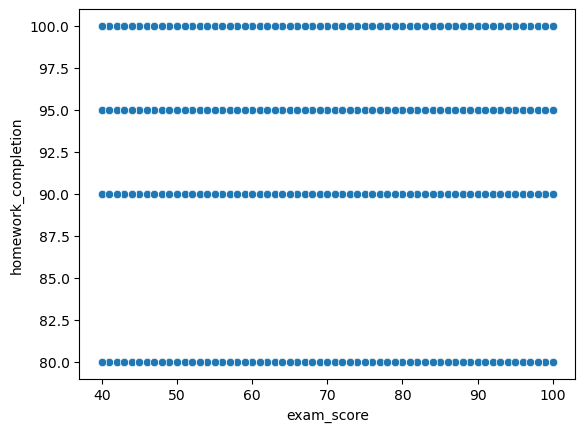

In [98]:
sns.scatterplot(data = performance, x = 'exam_score', y = 'homework_completion')

In [99]:
res = stats.pearsonr(performance['exam_score'], performance['homework_completion'])
print("Correlation (r):", res.statistic)
print("p-value:", res.pvalue)

Correlation (r): 0.0002850602332506139
p-value: 0.9640776079001575


There is no significant correlation between homework completion and exam scores.

## **Integrated Insights: Attendance vs Performance**

Do students with higher attendance rates have higher exam scores?

In [100]:
students_attendance_score_correlation = (students_attendance_summary[students_attendance_summary['attendance_status_updated']=='Attended Lesson']
                                .merge(performance, on = 'student_id', how = 'right')[['percentage', 'exam_score']])

<Axes: xlabel='percentage', ylabel='exam_score'>

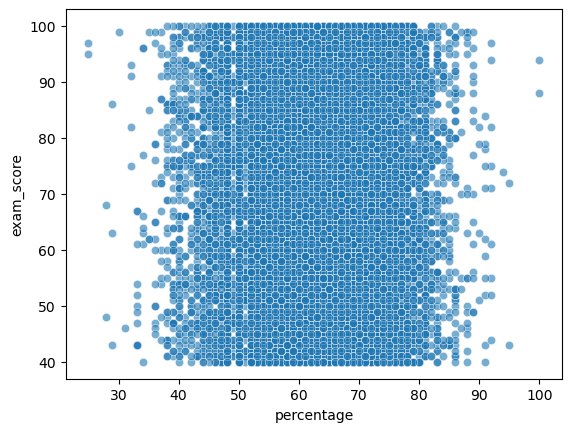

In [101]:
sns.scatterplot(data = students_attendance_score_correlation, x = 'percentage', y = 'exam_score', alpha = 0.6)

In [102]:
res = stats.pearsonr(students_attendance_score_correlation['exam_score'], students_attendance_score_correlation['percentage'])
print("Correlation (r):", res.statistic)
print("p-value:", res.pvalue)

Correlation (r): 0.009240344927464237
p-value: 0.14430861028745878


There is no significant correlation between attendance rate and exam scores.

At-risk students

| Metric                   | Threshold | Meaning             |
| :----------------------- | :-------- | :------------------ |
| Attendance Rate          | < 75%     | Often absent        |
| Average Exam Score       | < 60      | Low performance     |
| Homework Completion Rate | < 70%     | Not completing work |

In [105]:
query = """
WITH 
-- Attendance rate per student
attendance_summary AS (
    SELECT 
        student_id,
        ROUND(SUM(CASE WHEN attendance_status IN ('Late','Left Early','Present') THEN 1 ELSE 0 END) * 100.0 / COUNT(*), 2) AS attendance_rate
    FROM attendance_cleaned
    GROUP BY student_id
),

-- Exam score average per student
exam_summary AS (
    SELECT 
        student_id,
        ROUND(AVG(exam_score), 2) AS average_exam_score
    FROM performance_cleaned
    GROUP BY student_id
),

-- Homework completion and guardian signature rates per student
homework_summary AS (
    SELECT 
        student_id,
        ROUND(
            SUM(CASE WHEN status = 'Done' THEN 1 ELSE 0 END) * 100.0 / COUNT(*)
        , 2) AS homework_completion_rate,
        ROUND(AVG(guardian_signature) * 100, 2) AS guardian_signature_rate
    FROM homework_cleaned
    GROUP BY student_id
),

-- Combine all metrics into one summary table
student_summary AS (
    SELECT 
        s.student_id,
        s.full_name,
        a.attendance_rate,
        e.average_exam_score,
        h.homework_completion_rate,
        h.guardian_signature_rate
    FROM students_cleaned s
    LEFT JOIN attendance_summary a ON s.student_id = a.student_id
    LEFT JOIN exam_summary e ON s.student_id = e.student_id
    LEFT JOIN homework_summary h ON s.student_id = h.student_id
)

-- Classify risk levels
SELECT
    student_id,
    full_name,
    attendance_rate,
    average_exam_score,
    homework_completion_rate,
    guardian_signature_rate,
    CASE
        WHEN attendance_rate < 75 
          AND average_exam_score < 60 
          AND homework_completion_rate < 70 THEN 'High Risk'
        WHEN (attendance_rate < 75 AND average_exam_score < 60)
          OR (average_exam_score < 60 AND homework_completion_rate < 70)
          THEN 'Moderate Risk'
        ELSE 'Low Risk'
    END AS risk_level
FROM student_summary
WHERE average_exam_score IS NOT NULL  -- keep only students with exam data
ORDER BY 
    CASE risk_level
        WHEN 'High Risk' THEN 1
        WHEN 'Moderate Risk' THEN 2
        ELSE 3
    END,
    average_exam_score ASC;
"""

df_summary = pd.read_sql(query, engine)
df_summary.sample(5)

,student_id,full_name,attendance_rate,average_exam_score,homework_completion_rate,guardian_signature_rate,risk_level
810,S11337,Maria Bennett,54.55,52.60,50.00,100.0,High Risk
3101,S09681,Garrett Fisher,58.97,62.75,50.00,50.0,Low Risk
481,S04512,Bryan Kelley,52.38,49.00,50.00,50.0,High Risk
2915,S05435,Anna Esparza,64.00,62.00,16.67,20.0,Low Risk
1354,S02552,Brian Taylor,67.74,57.00,25.00,0.0,High Risk


In [104]:
df_summary.groupby('risk_level').size().reset_index(name='Count').sort_values('Count', ascending=False)

,risk_level,Count
1,Low Risk,8238
0,High Risk,1722
2,Moderate Risk,628
